We begin with a Band 6 image of the Orion Nebula.

In [11]:
import matplotlib.pyplot as plt
from astropy.io import fits
import matplotlib.image as mpimg
import astropy.units as u
from astropy.coordinates import Angle, SkyCoord
from astropy.table import Table,join
B6_pbcor_img = 'Orion_SourceI_B6_continuum_r-2.clean0.1mJy.selfcal.phase4.deepmask.allbaselines.image.tt0.pbcor.fits'

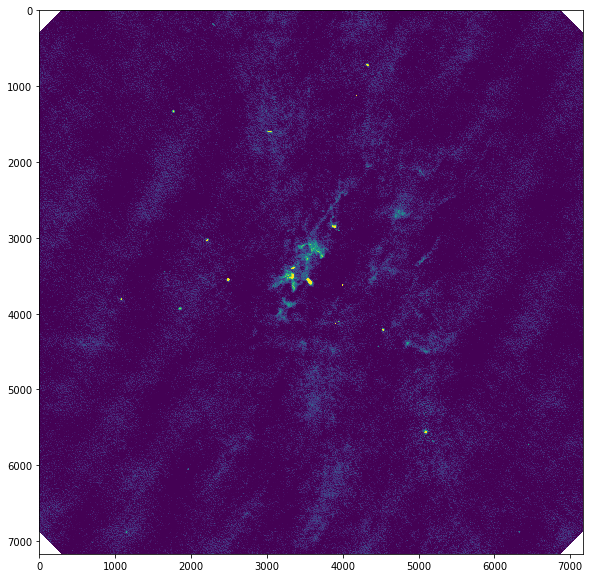

In [12]:
B6_img = 'Orion_SourceI_B6_continuum_r-2.clean0.1mJy.selfcal.phase4.deepmask.allbaselines.image.tt0.fits'
B6_data = fits.getdata(B6_img)
fig = plt.figure(figsize=(10,10))
plt.imshow(B6_data, vmin=1e-5, vmax=1e-3)

The first step is experiment with dendrogram parameters, primarily `min_value` and `min_delta`, to include all sources present and limit the number of noise sources. The function `compute_regions` computes the dendrogram for the image with the given parameters, and saves the dendrograms in both a catalog and a ds9 region file.

In [13]:
from region_file import compute_regions
min_val = 2e-4
min_del = 3.5e-4
npix = 10
reg_fname = 'B6_reg_file.reg'

In [4]:
dendrogram, catalog = compute_regions(min_val, min_del, npix, B6_img, reg_fname)

/users/jotter/anaconda3/lib/python3.6/site-packages/astrodendro/dendrogram.py:177: RuntimeWarning: invalid value encountered in greater
  keep = self.data > min_value


Computing catalog for 54 structures

[>                                        ] 1%
[=>                                       ] 3%
[==>                                      ] 5%
[==>                                      ] 7%
[===>                                     ] 9%
[====>                                    ] 11%
[=====>                                   ] 12%
[=====>                                   ] 14%
[======>                                  ] 16%
[=======>                                 ] 18%
[========>                                ] 20%
[========>                                ] 22%
[=========>                               ] 24%
[==========>                              ] 25%
[===========>                             ] 27%
[===========>                             ] 29%
[============>                            ] 31%
[=============>                           ] 33%
[==============>                          ] 35%
[==============>                          ] 37%
[=======


[==================>                      ] 46%
[===================>                     ] 48%
[====================>                    ] 50%
[====================>                    ] 51%
[=====================>                   ] 53%
[======================>                  ] 55%
[======================>                  ] 57%
[=======================>                 ] 59%
[========================>                ] 61%
[=========================>               ] 62%
[=========================>               ] 64%
[==========================>              ] 66%
[===========================>             ] 68%
[============================>            ] 70%
[============================>            ] 72%
[=============================>           ] 74%
[==============================>          ] 75%
[===============================>         ] 77%
[===============================>         ] 79%
[================================>        ] 81%
[=================================>    

Here is an image of the regions in ds9 of a central part of the B6 data. We won't want to include these extended sources, but we'll get to that later.

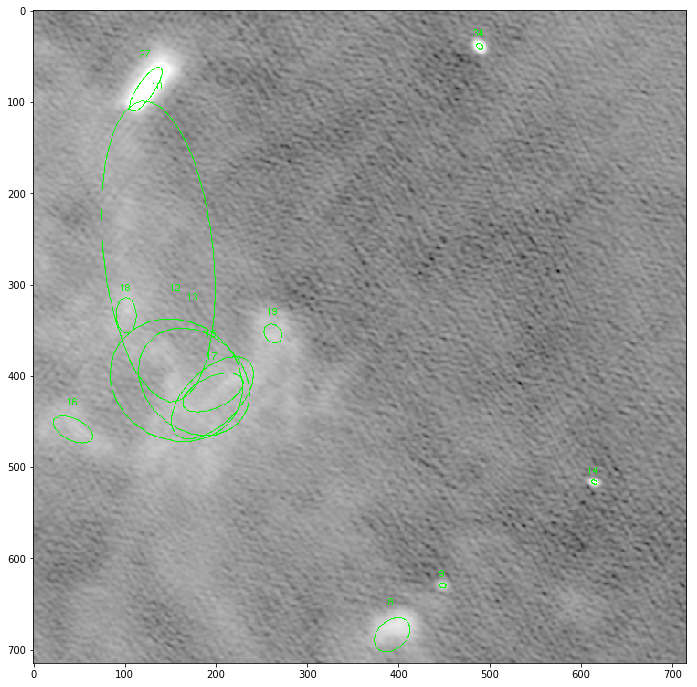

In [5]:
img=mpimg.imread('B6_central_regions.png')
fig = plt.figure(figsize=(12,12))
imgplot = plt.imshow(img)
plt.show()

Next, the above image file was not primary beam corrected because the increased noise on the edges had too many false detections. Thus to get physical values of flux we need to use the above dendrograms to measure flux in the primary beam corrected image. This can be done just by superposing the dendrograms onto the other image and measuring the flux from the pixels contained.

For any measurments with this data, we want a more accurate estimation of the centroid of the source than what the dendrogram says. To calculate the centroid, we fit a Gaussian to each source.

In [6]:
from gaussfit_catalog import gaussfit_catalog
from regions import CircleSkyRegion
cat_r = Angle(0.3, 'arcsecond')
regs = []
for ind in range(len(catalog['x_cen'])):
    regs.append(CircleSkyRegion(center=SkyCoord(catalog['x_cen'][ind]*u.degree, catalog['y_cen'][ind]*u.degree), radius=Angle(1, 'arcsecond'), meta={'text':str(catalog['_idx'][ind])}))

gauss_cat = gaussfit_catalog(B6_pbcor_img, regs, cat_r)

INFO: Noise estimate is 0.00013500726713341964 for file /users/jotter/summer_research_2018/pipeline/presentation_files/Orion_SourceI_B6_continuum_r-2.clean0.1mJy.selfcal.phase4.deepmask.allbaselines.image.tt0.pbcor.fits [gaussfit_catalog.core]
Could not deconvolve Beam: BMAJ=0.036998927593236 arcsec BMIN=0.021718168631197198 arcsec BPA=67.03914642334 deg from Beam: BMAJ=0.039388757825383654 arcsec BMIN=0.02665975367591417 arcsec BPA=153.40909212373043 deg
Could not deconvolve Beam: BMAJ=0.036998927593236 arcsec BMIN=0.021718168631197198 arcsec BPA=67.03914642334 deg from Beam: BMAJ=0.040555297560845756 arcsec BMIN=0.02676266064742837 arcsec BPA=152.23192261756512 deg
Could not deconvolve Beam: BMAJ=0.036998927593236 arcsec BMIN=0.021718168631197198 arcsec BPA=67.03914642334 deg from Beam: BMAJ=0.0162886264733979 arcsec BMIN=0.0162886264733979 arcsec BPA=200.76831513677868 deg
Could not deconvolve Beam: BMAJ=0.036998927593236 arcsec BMIN=0.021718168631197198 arcsec BPA=67.03914642334 de

We can view the Gaussian fit for each source, below is source 34 shown earlier. The top left panel is the data, the top right is the fit, the bottom left is the residual, and the bottom right is the data with superimposed contours. The fit for this source looks very good!

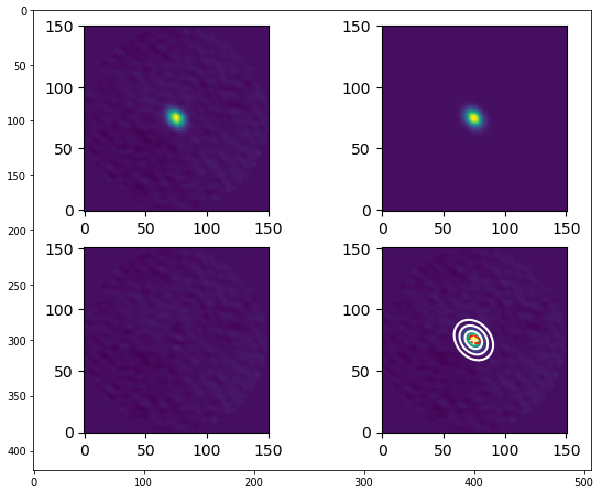

In [7]:
img=mpimg.imread('34.png')
fig = plt.figure(figsize=(10,10))
imgplot = plt.imshow(img)
plt.show()

In [8]:
name='B6'
gauss_fit_tab = Table(names=('_idx', 'gauss_x_'+name, 'gauss_y_'+name, 'FWHM_major_'+name, 'FWHM_minor_'+name, 'position_angle_'+name, 'peak_flux_'+name, 'gauss_amplitude_'+name, 'fit_goodness'), dtype=('i4','f8','f8','f8','f8','f8','f8','f8','U10')) #turn into astropy table
for key in gauss_cat:
	gauss_fit_tab.add_row((key,gauss_cat[key]['center_x'],gauss_cat[key]['center_y'], gauss_cat[key]['fwhm_major'], gauss_cat[key]['fwhm_minor'], gauss_cat[key]['pa'], gauss_cat[key]['peak'], gauss_cat[key]['amplitude'], 'none')) #fill table
full_cat = join(catalog, gauss_fit_tab, keys='_idx', join_type='outer') #joining the gaussian centroid data with the rest


The dendrogram catalog creation, primary beam corrected flux measurement, and gaussian fitting is all contained in the program `dendrogram_catalog.py` which accepts a file of parameters for each data image as input.

Combining the centroids from the gaussian fits with the rest of the data, we are left with the entire catalog of sources with correct centroids and fluxes. Next we remove some of the 'bad' sources shown previously with two criteria: signal to noise ratio and size (because we are not interested in extended sources).

In [14]:
from snr_rejection_jupyter import reject_sources
catalog = 'B6_dendro_catalog_all.fits'
img_data = B6_pbcor_img
min_snr = 4.5
max_size_ID = 23
table = reject_sources(catalog, img_data, min_snr, max_size_ID)

SNR is calculated in an annulus around the source, and the maximum size can be set in degrees or with the ID of the largest 'real' source. In the following, greyed out images were rejected with these parameters. Other sources which should be rejected/accepted can be manually input. Some of these sources aren't fit well with a gaussian, so alternatives should be explored

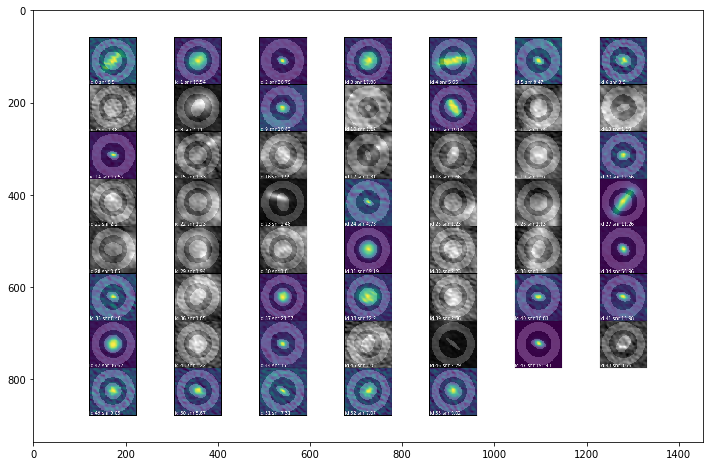

In [15]:
img=mpimg.imread('snr_rejection.png')
fig = plt.figure(figsize=(12,12))
imgplot = plt.imshow(img)
plt.show()

Next, we do this process for other data sets of the same region (different in frequency and/or time) and match the resulting catalogs. These catalogs are matched by sky coordinates and each source is given an ID. With varying resolution across data sets, many sources are detected in some and not others.

We can compare fluxes in different bands and with the sky distances we can measure the proper motions.